# 1. Business Understanding
- Mengembangkan Model SImulasi Otomatisasi HIdroponik mas dengan model Prophet dan Arima
- Membandingkan 2 Metode Algoritma Prophet dan ARIMA mana yang terbaik dan efektif.
- Mengembangkan Aplikasi Simulasi Hidroponik (HydroSim) untuk mlakukan simulasi otomasisasi hidroponik tanaman selada dengan menggunakan model terbaik


# 2. Data Understanding

In [2]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from tabulate import tabulate
from sklearn.metrics import confusion_matrix

## Load Dataset

In [101]:
df_train = pd.read_csv("/content/DataFieldFULLSIOHITrainFULLPattern01072024.csv")
df_test = pd.read_csv("/content/DataFieldFULLSIOHITest01072024.csv")

In [102]:
print(len(df_train))
print(len(df_test))

8000
6400


In [69]:
df_train.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
0,1,1,9.19,26.8,72,17820,7.2,677,340,26.1,Selada,3
1,1,2,9.23,26.6,72,16490,7.2,677,338,26.1,Selada,3
2,1,3,9.27,26.4,72,15160,7.2,678,334,26.1,Selada,3
3,1,4,9.31,26.2,72,13830,7.2,677,338,26.1,Selada,3
4,1,5,9.35,26.2,72,12500,7.2,673,340,26.1,Selada,3


In [70]:
df_train.tail()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,Label,LeafCount
7995,40,1,16.24,27.9,58,41810,7.3,2258,1129,23.9,Selada,16
7996,40,2,16.26,27.5,58,41520,7.3,2342,1171,23.9,Selada,12
7997,40,3,16.28,27.1,58,41230,7.3,2361,1180,23.9,Selada,13
7998,40,4,16.29,27.8,58,41940,7.3,2378,1189,23.9,Selada,16
7999,40,5,16.32,27.9,58,41650,7.3,2306,1153,23.9,Selada,19


### EDA

In [71]:
df_train.columns

Index(['day', 'hole', 'time', 'temperature', 'humidity', 'light', 'pH', 'EC',
       'TDS', 'WaterTemp', 'Label', 'LeafCount'],
      dtype='object')

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          8000 non-null   int64  
 1   hole         8000 non-null   int64  
 2   time         8000 non-null   float64
 3   temperature  8000 non-null   float64
 4   humidity     8000 non-null   int64  
 5   light        8000 non-null   int64  
 6   pH           8000 non-null   float64
 7   EC           8000 non-null   int64  
 8   TDS          8000 non-null   int64  
 9   WaterTemp    8000 non-null   float64
 10  Label        8000 non-null   object 
 11  LeafCount    8000 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 750.1+ KB


In [73]:
# Check missing data

missing_data = pd.DataFrame({'total_missing': df_train.isnull().sum(),
                             'perc_missing': (df_train.isnull().sum()/2634)*100})

missing_data

,total_missing,perc_missing
day,0,0.0
hole,0,0.0
time,0,0.0
temperature,0,0.0
humidity,0,0.0
light,0,0.0
pH,0,0.0
EC,0,0.0
TDS,0,0.0
WaterTemp,0,0.0


In [103]:
df_train.describe()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,20.500000,5.000000,12.878269,27.147687,69.978750,30548.134375,7.185200,1332.533625,665.670500,27.194700,8.366000
std,11.544118,2.828604,2.761630,1.958960,16.376334,17976.792892,0.304376,493.701284,246.395326,2.946802,4.016536
min,1.000000,1.000000,7.370000,23.100000,40.000000,9003.000000,6.400000,514.000000,258.000000,22.300000,3.000000
25%,10.750000,3.000000,10.945000,25.700000,57.000000,17180.000000,6.900000,686.000000,348.000000,24.900000,5.000000
50%,20.500000,5.000000,13.225000,26.800000,69.000000,28830.000000,7.200000,1538.000000,760.000000,26.500000,8.000000
75%,30.250000,7.000000,15.405000,28.100000,84.000000,41422.500000,7.300000,1599.000000,799.000000,28.900000,11.000000
max,40.000000,10.000000,17.020000,32.600000,99.000000,168770.000000,8.200000,2467.000000,1758.000000,34.100000,20.000000


In [104]:
df_train = df_train.drop(columns=['Label'])
df_test = df_test.drop(columns=['Label'])

In [105]:
# Correlation Matrix
cor_matrix = df_train.corr()
cor_matrix

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
day,1.000000e+00,1.249092e-16,0.003883,-0.171041,0.144791,-0.107481,0.281429,0.829152,0.830171,-0.537363,0.890994
hole,1.249092e-16,1.000000e+00,0.029839,0.013435,0.000918,-0.025341,-0.028576,-0.125153,-0.124434,-0.012963,0.064658
time,3.883354e-03,2.983932e-02,1.000000,0.235844,-0.513122,0.364059,0.225903,0.008172,0.007146,0.457679,0.008695
temperature,-1.710405e-01,1.343533e-02,0.235844,1.000000,-0.362850,0.210620,0.023773,-0.144243,-0.144734,0.408470,-0.168226
humidity,1.447911e-01,9.176021e-04,-0.513122,-0.362850,1.000000,-0.354230,-0.046467,0.122619,0.121974,-0.421257,0.113101
light,-1.074807e-01,-2.534086e-02,0.364059,0.210620,-0.354230,1.000000,0.003685,-0.121969,-0.120875,0.365463,-0.071180
pH,2.814291e-01,-2.857631e-02,0.225903,0.023773,-0.046467,0.003685,1.000000,0.295695,0.294266,-0.073158,0.152390
EC,8.291518e-01,-1.251526e-01,0.008172,-0.144243,0.122619,-0.121969,0.295695,1.000000,0.997981,-0.434209,0.718760
TDS,8.301709e-01,-1.244343e-01,0.007146,-0.144734,0.121974,-0.120875,0.294266,0.997981,1.000000,-0.435360,0.720149
WaterTemp,-5.373625e-01,-1.296301e-02,0.457679,0.408470,-0.421257,0.365463,-0.073158,-0.434209,-0.435360,1.000000,-0.489908


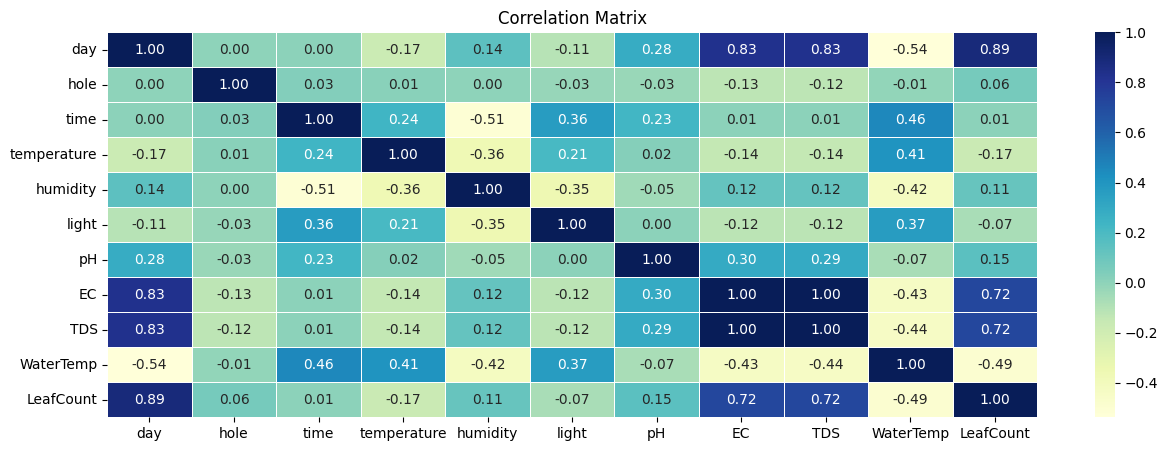

In [106]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15, 5))
sns.heatmap(cor_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Visualisasi

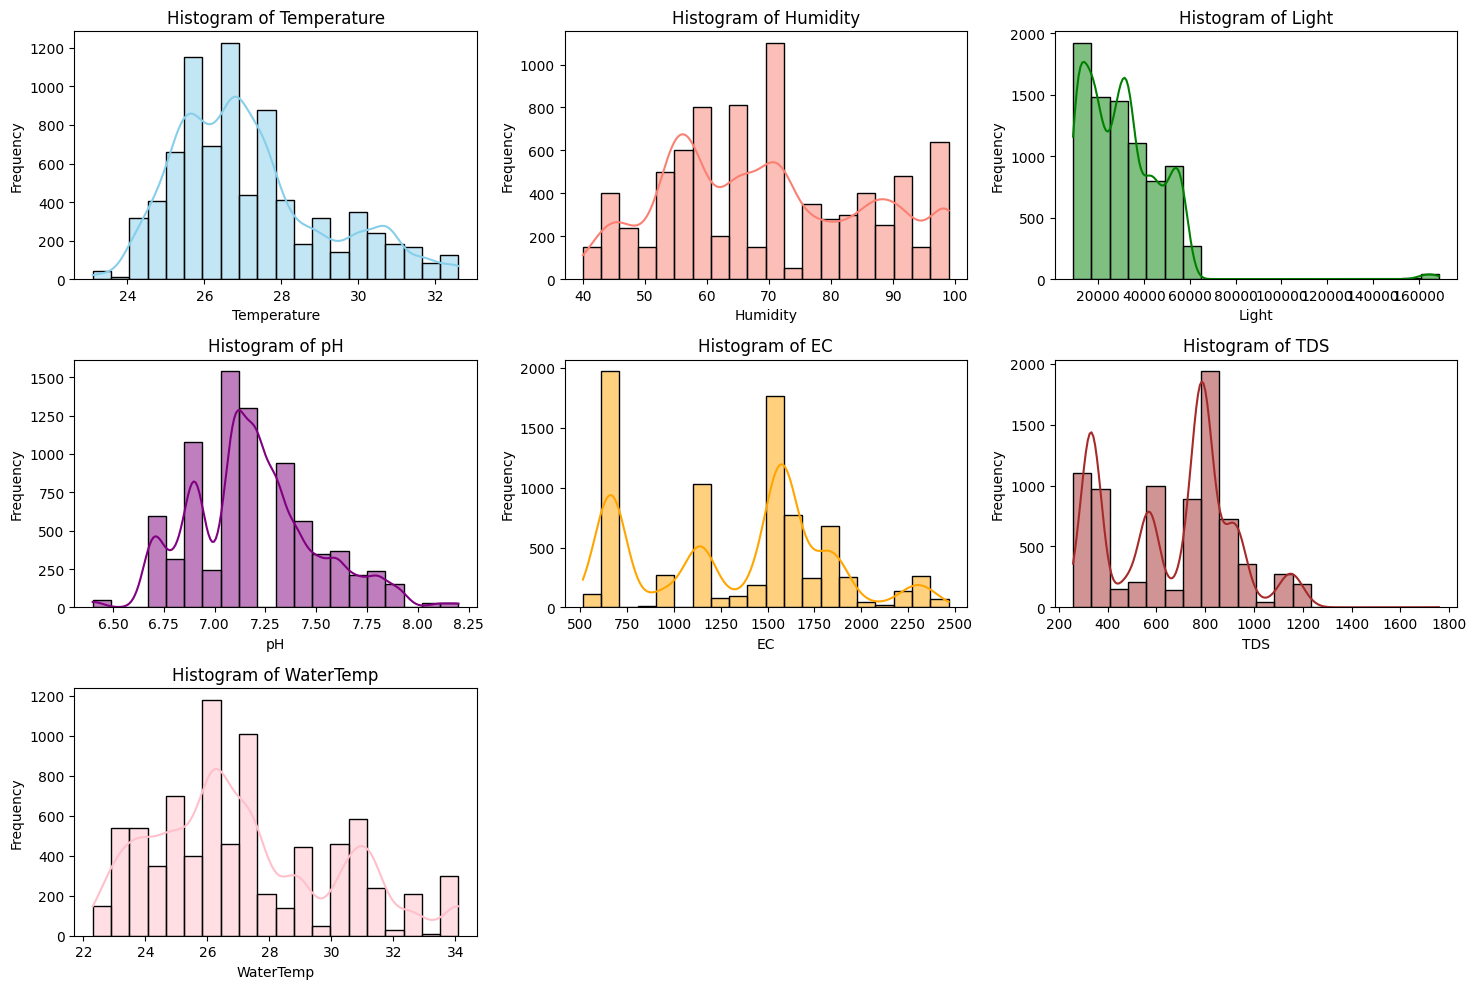

In [107]:
# Plotting histograms
plt.figure(figsize=(15, 10))

# Histogram for 'temperature'
plt.subplot(3, 3, 1)
sns.histplot(df_train['temperature'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Histogram for 'humidity'
plt.subplot(3, 3, 2)
sns.histplot(df_train['humidity'], bins=20, kde=True, color='salmon')
plt.title('Histogram of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Frequency')

# Histogram for 'light'
plt.subplot(3, 3, 3)
sns.histplot(df_train['light'], bins=20, kde=True, color='green')
plt.title('Histogram of Light')
plt.xlabel('Light')
plt.ylabel('Frequency')

# Histogram for 'pH'
plt.subplot(3, 3, 4)
sns.histplot(df_train['pH'], bins=20, kde=True, color='purple')
plt.title('Histogram of pH')
plt.xlabel('pH')
plt.ylabel('Frequency')

# Histogram for 'EC'
plt.subplot(3, 3, 5)
sns.histplot(df_train['EC'], bins=20, kde=True, color='orange')
plt.title('Histogram of EC')
plt.xlabel('EC')
plt.ylabel('Frequency')

# Histogram for 'TDS'
plt.subplot(3, 3, 6)
sns.histplot(df_train['TDS'], bins=20, kde=True, color='brown')
plt.title('Histogram of TDS')
plt.xlabel('TDS')
plt.ylabel('Frequency')

# Histogram for 'WaterTemp'
plt.subplot(3, 3, 7)
sns.histplot(df_train['WaterTemp'], bins=20, kde=True, color='pink')
plt.title('Histogram of WaterTemp')
plt.xlabel('WaterTemp')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Visualisasi Terhadap Hari

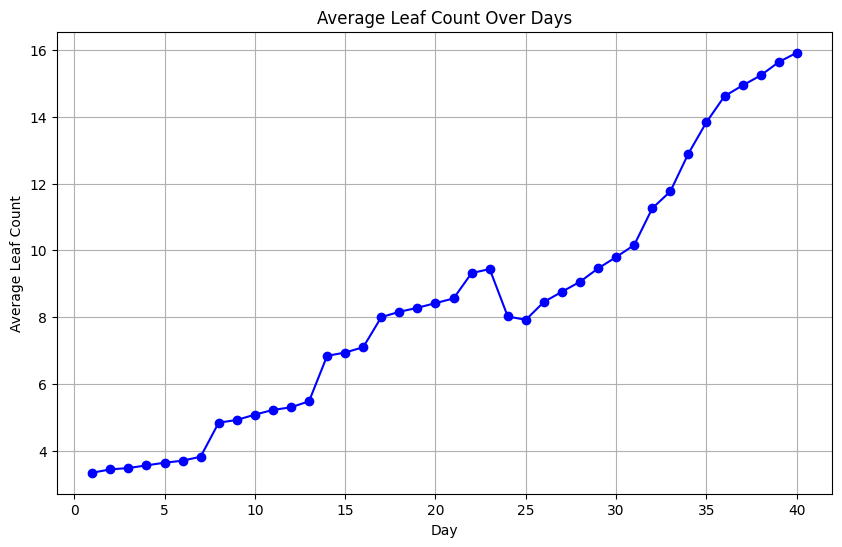

In [108]:
# Group by 'day' and calculate the mean of 'LeafCount'
average_leaf_count = df_train.groupby('day')['LeafCount'].mean().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(average_leaf_count['day'], average_leaf_count['LeafCount'], marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Average Leaf Count Over Days')
plt.xlabel('Day')
plt.ylabel('Average Leaf Count')

# Display the plot
plt.grid(True)
plt.show()

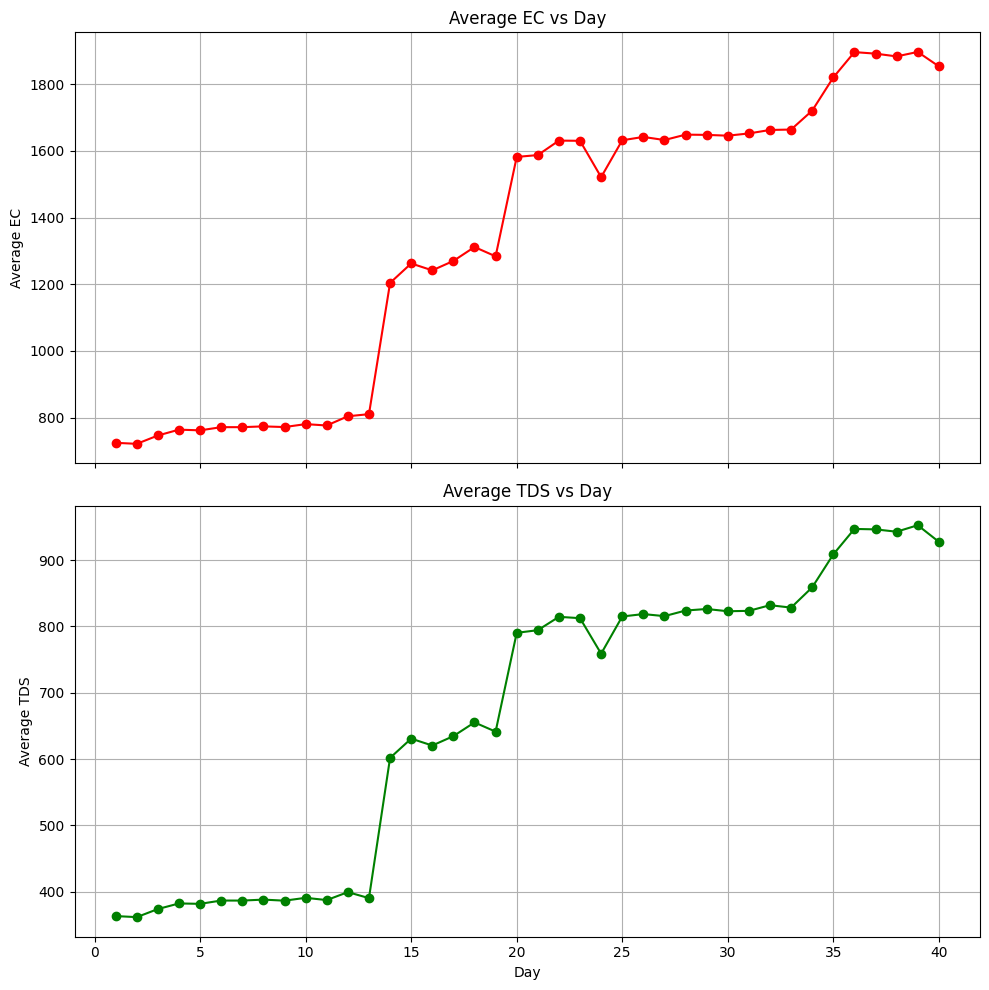

In [109]:
# Group by 'day' and calculate the mean of 'EC' and 'TDS'
average_values = df_train.groupby('day')[['EC', 'TDS']].mean().reset_index()

# Creating the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plotting average EC vs day
axs[0].plot(average_values['day'], average_values['EC'], marker='o', linestyle='-', color='r')
axs[0].set_title('Average EC vs Day')
axs[0].set_ylabel('Average EC')
axs[0].grid(True)

# Plotting average TDS vs day
axs[1].plot(average_values['day'], average_values['TDS'], marker='o', linestyle='-', color='g')
axs[1].set_title('Average TDS vs Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average TDS')
axs[1].grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()

#### Visualisasi dengan Jumlah Daun

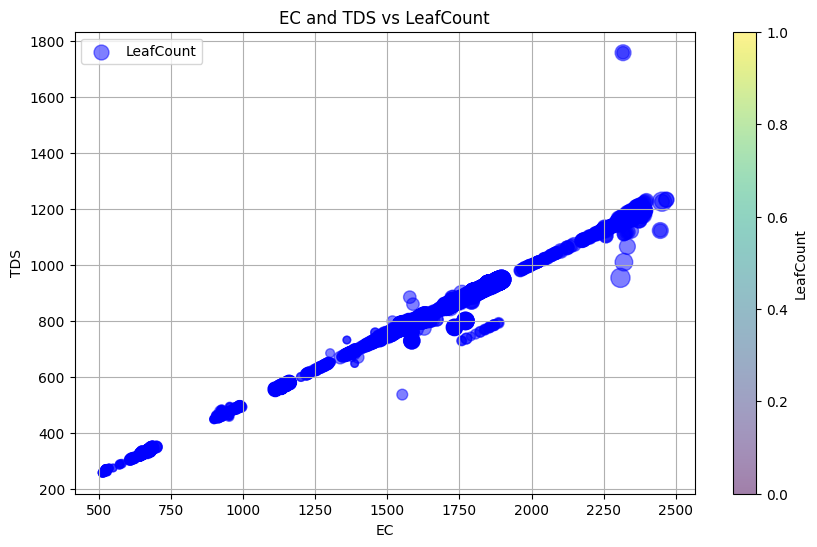

In [110]:
# Plotting EC vs TDS with LeafCount as marker size
plt.figure(figsize=(10, 6))
plt.scatter(df_train['EC'], df_train['TDS'], s=df_train['LeafCount']*10, alpha=0.5, c='blue', label='LeafCount')
plt.title('EC and TDS vs LeafCount')
plt.xlabel('EC')
plt.ylabel('TDS')
plt.colorbar(label='LeafCount')
plt.legend()

plt.grid(True)
plt.show()

# 3. Data Preparation

In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          8000 non-null   int64  
 1   hole         8000 non-null   int64  
 2   time         8000 non-null   float64
 3   temperature  8000 non-null   float64
 4   humidity     8000 non-null   int64  
 5   light        8000 non-null   int64  
 6   pH           8000 non-null   float64
 7   EC           8000 non-null   int64  
 8   TDS          8000 non-null   int64  
 9   WaterTemp    8000 non-null   float64
 10  LeafCount    8000 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 687.6 KB


In [112]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [113]:
df_train_copy['time']
df_test_copy['time']

0        9.19
1        9.23
2        9.27
3        9.31
4        9.35
        ...  
6395    16.38
6396    16.42
6397    16.43
6398    16.44
6399    16.45
Name: time, Length: 6400, dtype: float64

In [114]:
# Tambahkan "0" di depan nilai yang hanya satu digit di bagian jam
df_train_copy['time'] = df_train_copy['time'].apply(lambda x: '{:.2f}'.format(x))
df_test_copy['time'] = df_test_copy['time'].apply(lambda x: '{:.2f}'.format(x))

# Konversi 'time' ke format waktu yang benar
df_train_copy['time'] = pd.to_datetime(df_train_copy['time'], format='%H.%M').dt.time
df_test_copy['time'] = pd.to_datetime(df_test_copy['time'], format='%H.%M').dt.time

In [115]:
df_train_copy

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
0,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3
1,1,2,09:23:00,26.6,72,16490,7.2,677,338,26.1,3
2,1,3,09:27:00,26.4,72,15160,7.2,678,334,26.1,3
3,1,4,09:31:00,26.2,72,13830,7.2,677,338,26.1,3
4,1,5,09:35:00,26.2,72,12500,7.2,673,340,26.1,3
...,...,...,...,...,...,...,...,...,...,...,...
7995,40,1,16:24:00,27.9,58,41810,7.3,2258,1129,23.9,16
7996,40,2,16:26:00,27.5,58,41520,7.3,2342,1171,23.9,12
7997,40,3,16:28:00,27.1,58,41230,7.3,2361,1180,23.9,13
7998,40,4,16:29:00,27.8,58,41940,7.3,2378,1189,23.9,16


In [116]:
df_test_copy

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
0,1,1,09:19:00,26.8,72,17820,7.1,918,459,26.1,3
1,1,2,09:23:00,26.6,72,16490,7.1,918,459,26.1,3
2,1,3,09:27:00,26.4,72,15160,7.1,915,454,26.1,3
3,1,4,09:31:00,26.2,72,13830,7.1,915,457,26.1,3
4,1,5,09:35:00,26.2,72,12500,7.1,918,461,26.1,4
...,...,...,...,...,...,...,...,...,...,...,...
6395,40,1,16:38:00,27.8,57,42170,7.9,2318,1159,25.3,16
6396,40,2,16:42:00,27.1,57,42760,7.9,2300,1150,25.3,12
6397,40,3,16:43:00,27.2,57,43350,7.9,2386,1193,25.3,13
6398,40,4,16:44:00,27.6,57,43940,7.9,2386,1180,25.3,16


In [117]:
df_train_prep = df_train_copy.copy()
df_test_prep = df_test_copy.copy()

In [118]:
df_train_prep = df_train_prep[['day', 'time', 'LeafCount']]
df_test_prep = df_test_prep[['day', 'time', 'LeafCount']]

In [119]:
# Tentukan tanggal awal
start_date = pd.to_datetime('2024-07-01')

In [120]:
# Ubah kolom 'time' menjadi string
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_test_prep['time'] = df_test_prep['time'].astype(str)

# Buat kolom 'datetime' dengan menambahkan 'day' ke tanggal awal dan menggabungkan dengan 'time'
df_train_prep['datetime'] = df_train_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)
df_test_prep['datetime'] = df_test_prep.apply(lambda row: start_date + pd.Timedelta(days=row['day'] - 1) + pd.to_timedelta(row['time']), axis=1)


In [121]:
print(df_train_prep.head())

   day      time  LeafCount            datetime
0    1  09:19:00          3 2024-07-01 09:19:00
1    1  09:23:00          3 2024-07-01 09:23:00
2    1  09:27:00          3 2024-07-01 09:27:00
3    1  09:31:00          3 2024-07-01 09:31:00
4    1  09:35:00          3 2024-07-01 09:35:00


### Data Pre-Processing

In [123]:
print(df_test_prep.head())

   day      time  LeafCount            datetime
0    1  09:19:00          3 2024-07-01 09:19:00
1    1  09:23:00          3 2024-07-01 09:23:00
2    1  09:27:00          3 2024-07-01 09:27:00
3    1  09:31:00          3 2024-07-01 09:31:00
4    1  09:35:00          4 2024-07-01 09:35:00


In [124]:
df_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   day        6400 non-null   int64         
 1   time       6400 non-null   object        
 2   LeafCount  6400 non-null   int64         
 3   datetime   6400 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 200.1+ KB


In [94]:
# Convert to correct data types
df_train_prep['day'] = df_train_prep['day'].astype(int)
df_train_prep['time'] = df_train_prep['time'].astype(str)
df_train_prep['LeafCount'] = df_train_prep['LeafCount'].astype(int)

# Convert to correct data types
df_test_prep['day'] = df_test_prep['day'].astype(int)
df_test_prep['time'] = df_test_prep['time'].astype(str)
df_test_prep['LeafCount'] = df_test_prep['LeafCount'].astype(int)

In [125]:
df_train_prep

,day,time,LeafCount,datetime
0,1,09:19:00,3,2024-07-01 09:19:00
1,1,09:23:00,3,2024-07-01 09:23:00
2,1,09:27:00,3,2024-07-01 09:27:00
3,1,09:31:00,3,2024-07-01 09:31:00
4,1,09:35:00,3,2024-07-01 09:35:00
...,...,...,...,...
7995,40,16:24:00,16,2024-08-09 16:24:00
7996,40,16:26:00,12,2024-08-09 16:26:00
7997,40,16:28:00,13,2024-08-09 16:28:00
7998,40,16:29:00,16,2024-08-09 16:29:00


In [127]:
# Convert to correct data types
df_train_copy['day'] = df_train_copy['day'].astype(int)
df_train_copy['time'] = df_train_copy['time'].astype(str)
df_train_copy['LeafCount'] = df_train_copy['LeafCount'].astype(int)

df_test_copy['day'] = df_test_copy['day'].astype(int)
df_test_copy['time'] = df_test_copy['time'].astype(str)
df_test_copy['LeafCount'] = df_test_copy['LeafCount'].astype(int)

In [128]:
# Merge the 'datetime' column from df_prep into df_copy
df_train_model = pd.merge(df_train_copy, df_train_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')
df_test_model = pd.merge(df_test_copy, df_test_prep[['day', 'time', 'LeafCount', 'datetime']], on=['day', 'time', 'LeafCount'], how='inner')

# Debug: Check the result of the merge
print("df_model after merge:")
print(df_train_model.head())

df_model after merge:
   day  hole      time  temperature  humidity  light   pH   EC  TDS  \
0    1     1  09:19:00         26.8        72  17820  7.2  677  340   
1    1     1  09:19:00         26.8        72  17820  7.2  677  340   
2    1     1  09:19:00         26.8        72  17820  7.2  677  340   
3    1     1  09:19:00         26.8        72  17820  7.2  677  340   
4    1     2  09:23:00         26.6        72  16490  7.2  677  338   

   WaterTemp  LeafCount            datetime  
0       26.1          3 2024-07-01 09:19:00  
1       26.1          3 2024-07-01 09:19:00  
2       26.1          3 2024-07-01 09:19:00  
3       26.1          3 2024-07-01 09:19:00  
4       26.1          3 2024-07-01 09:23:00  


In [129]:
df_train_model

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount,datetime
0,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3,2024-07-01 09:19:00
1,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3,2024-07-01 09:19:00
2,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3,2024-07-01 09:19:00
3,1,1,09:19:00,26.8,72,17820,7.2,677,340,26.1,3,2024-07-01 09:19:00
4,1,2,09:23:00,26.6,72,16490,7.2,677,338,26.1,3,2024-07-01 09:23:00
...,...,...,...,...,...,...,...,...,...,...,...,...
16135,40,1,16:24:00,27.9,58,41810,7.3,2258,1129,23.9,16,2024-08-09 16:24:00
16136,40,2,16:26:00,27.5,58,41520,7.3,2342,1171,23.9,12,2024-08-09 16:26:00
16137,40,3,16:28:00,27.1,58,41230,7.3,2361,1180,23.9,13,2024-08-09 16:28:00
16138,40,4,16:29:00,27.8,58,41940,7.3,2378,1189,23.9,16,2024-08-09 16:29:00


In [130]:
df_test_model

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount,datetime
0,1,1,09:19:00,26.8,72,17820,7.1,918,459,26.1,3,2024-07-01 09:19:00
1,1,2,09:23:00,26.6,72,16490,7.1,918,459,26.1,3,2024-07-01 09:23:00
2,1,3,09:27:00,26.4,72,15160,7.1,915,454,26.1,3,2024-07-01 09:27:00
3,1,4,09:31:00,26.2,72,13830,7.1,915,457,26.1,3,2024-07-01 09:31:00
4,1,4,09:31:00,26.2,72,13830,7.1,915,457,26.1,3,2024-07-01 09:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...
17145,40,5,14:31:00,26.2,58,33550,7.8,1859,929,25.4,14,2024-08-09 14:31:00
17146,40,5,14:31:00,26.2,58,33550,7.8,1859,929,25.4,14,2024-08-09 14:31:00
17147,40,1,16:33:00,26.9,57,49220,7.9,1832,916,25.3,18,2024-08-09 16:33:00
17148,40,4,16:36:00,27.6,57,40990,7.9,1826,913,25.3,14,2024-08-09 16:36:00


In [131]:
df_test_model.duplicated().sum()

10768

In [132]:
df_train_model.duplicated().sum()

8729

In [133]:
# Drop duplicates
df_train_model = df_train_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])
df_test_model = df_test_model.drop_duplicates(subset=['day', 'time', 'LeafCount'])

In [136]:
# Set the 'datetime' column as the index and sort it
df_train_model.set_index('datetime', inplace=True)
df_train_model = df_train_model.sort_index()

# Set the 'datetime' column as the index and sort it
df_test_model.set_index('datetime', inplace=True)
df_test_model = df_test_model.sort_index()



In [137]:
# Ensure that the data is sorted by datetime
df_train_model = df_train_model.sort_index()
df_test_model = df_test_model.sort_index()

In [138]:
# save dataframe to csv
df_train_model.to_csv('dataset_train_final.csv')
df_test_model.to_csv('dataset_test_final.csv')

# Modelling

In [168]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [169]:
# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

## Detail DF Train

In [170]:
df_train

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
datetime,,,,,,,,,,,
2024-07-01 08:55:00,1,1,08:55:00,25.3,92,21910,7.0,660,330,23.1,3
2024-07-01 08:57:00,1,2,08:57:00,25.3,92,21910,7.0,660,330,23.1,3
2024-07-01 08:59:00,1,3,08:59:00,25.5,92,21060,7.8,984,492,26.1,3
2024-07-01 08:59:00,1,3,08:59:00,25.5,92,21060,7.0,652,326,23.1,4
2024-07-01 09:02:00,1,4,09:02:00,25.7,92,28330,7.0,656,328,23.1,3
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09 16:44:00,40,9,16:44:00,25.6,44,12820,7.5,1851,930,26.3,18
2024-08-09 16:44:00,40,9,16:44:00,25.6,44,12820,7.5,1851,930,23.9,16
2024-08-09 16:45:00,40,10,16:45:00,25.4,44,16810,7.5,1886,943,23.9,15


In [142]:
df_train.columns

Index(['day', 'hole', 'time', 'temperature', 'humidity', 'light', 'pH', 'EC',
       'TDS', 'WaterTemp', 'LeafCount'],
      dtype='object')

## Detail DF Test

In [143]:
df_test

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
datetime,,,,,,,,,,,
2024-07-01 09:19:00,1,1,09:19:00,26.8,72,17820,7.1,918,459,26.1,3
2024-07-01 09:23:00,1,2,09:23:00,26.6,72,16490,7.1,918,459,26.1,3
2024-07-01 09:27:00,1,3,09:27:00,26.4,72,15160,7.1,915,454,26.1,3
2024-07-01 09:28:00,1,1,09:28:00,26.8,72,17820,6.9,677,340,26.1,3
2024-07-01 09:29:00,1,10,09:29:00,26.9,72,15850,6.9,677,338,26.1,4
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09 16:43:00,40,8,16:43:00,27.2,57,43350,7.9,1766,883,25.3,10
2024-08-09 16:44:00,40,4,16:44:00,25.6,44,12820,7.4,2426,1213,30.1,16
2024-08-09 16:44:00,40,9,16:44:00,27.6,57,43940,7.9,1705,853,25.3,17


In [144]:
df_test.columns

Index(['day', 'hole', 'time', 'temperature', 'humidity', 'light', 'pH', 'EC',
       'TDS', 'WaterTemp', 'LeafCount'],
      dtype='object')

## ARIMA Model

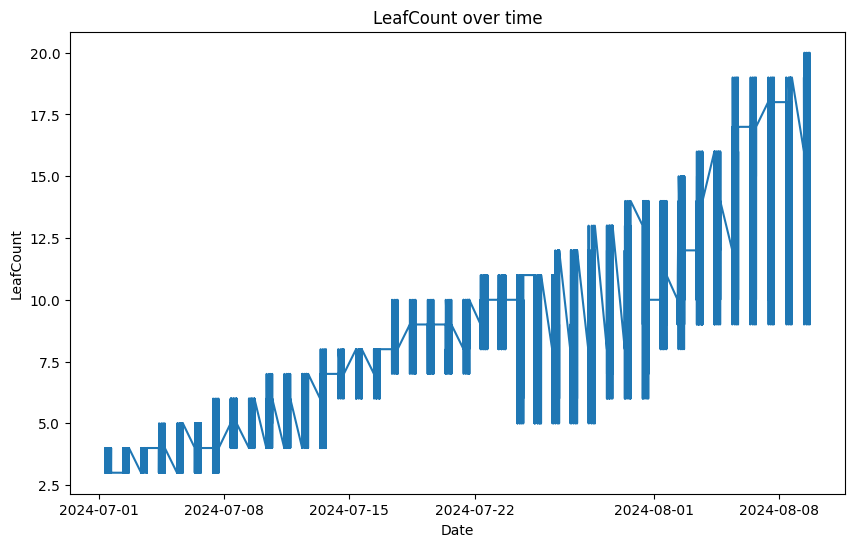

In [171]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(df_train['LeafCount'])
plt.title('LeafCount over time')
plt.xlabel('Date')
plt.ylabel('LeafCount')
plt.show()

In [172]:
# Check stationarity
result = adfuller(df_train['LeafCount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.5174725085855295
p-value: 0.888561518088422
Critical Values:
   1%, -3.4315964280482922
Critical Values:
   5%, -2.862090792166715
Critical Values:
   10%, -2.5670631863496958


In [173]:
# Differencing to make the series stationary
df_train['LeafCount_diff'] = df_train['LeafCount'] - df_train['LeafCount'].shift(1)
df_train.dropna(inplace=True)

result = adfuller(df_train['LeafCount_diff'])
print('ADF Statistic after differencing:', result[0])
print('p-value after differencing:', result[1])

ADF Statistic after differencing: -22.305309614491097
p-value after differencing: 0.0


<ipython-input-174-ccd4e4186c5b>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem(range(len(acf_values)), acf_values, use_line_collection=True)
<ipython-input-174-ccd4e4186c5b>:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem(range(len(pacf_values)), pacf_values, use_line_collection=True)


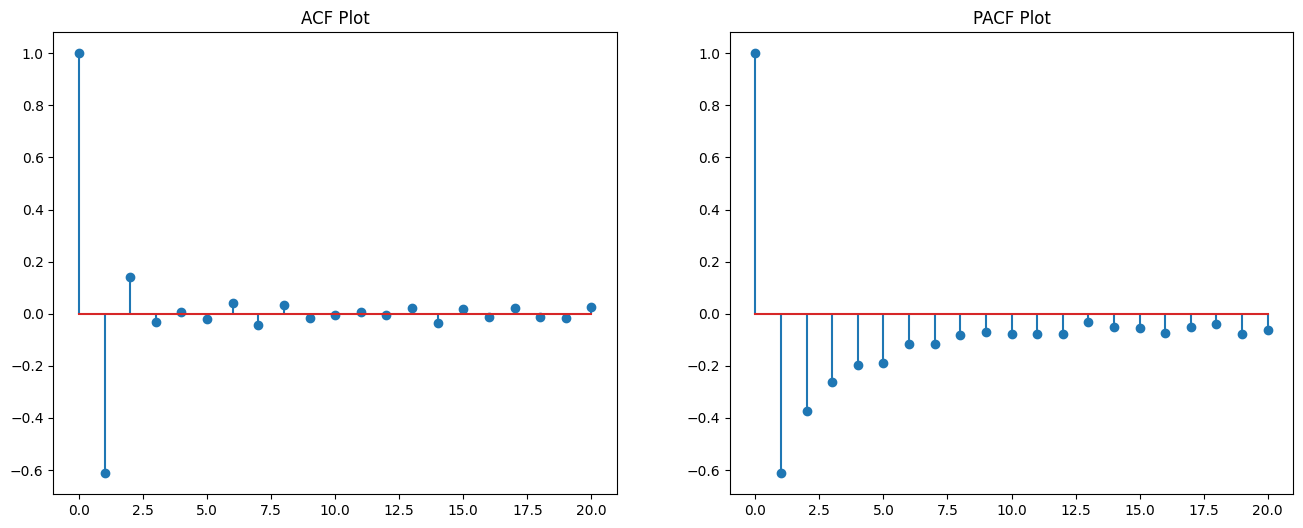

In [174]:
# Determine p, d, q using ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
acf_values = acf(df_train['LeafCount_diff'], nlags=20)
pacf_values = pacf(df_train['LeafCount_diff'], nlags=20)

ax[0].stem(range(len(acf_values)), acf_values, use_line_collection=True)
ax[0].set_title('ACF Plot')
ax[1].stem(range(len(pacf_values)), pacf_values, use_line_collection=True)
ax[1].set_title('PACF Plot')

plt.show()

In [175]:
# Fit the ARIMA model
# Replace p, d, q with appropriate values from ACF and PACF plots
p = 1  # Typically based on PACF plot
d = 1  # Differencing order
q = 1  # Typically based on ACF plot

In [176]:
model = ARIMA(df_train['LeafCount'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              LeafCount   No. Observations:                 5282
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10246.137
Date:                Mon, 22 Jul 2024   AIC                          20498.274
Time:                        02:54:26   BIC                          20517.990
Sample:                             0   HQIC                         20505.165
                               - 5282                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1913      0.012    -16.310      0.000      -0.214      -0.168
ma.L1         -0.9682      0.003   -314.518      0.000      -0.974      -0.962
sigma2         2.8346      0.051     55.715      0.0

In [178]:
# Check if there are any warnings or errors during fitting
if not model_fit.mle_retvals['converged']:
    print("Warning: Model fitting did not converge properly.")

In [207]:
# Predict on the Test Data
start = len(df_train)
end = start + len(df_test) - 1
predictions = model_fit.predict(start=start, end=end, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [208]:
# Calculate Evaluation Metrics (RMSE and MAE)
rmse = np.sqrt(mean_squared_error(df_test['LeafCount'], predictions))
mae = mean_absolute_error(df_test['LeafCount'], predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 8.970086115676192
MAE: 8.170746410714356


In [209]:
forecast_result = model_fit.get_forecast(steps=30)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [210]:
# Create a DataFrame to hold the results
forecast_dates = pd.date_range(start=df_train.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast.values, 'Lower CI': conf_int.iloc[:, 0].values, 'Upper CI': conf_int.iloc[:, 1].values}, index=forecast_dates)

In [211]:
# Display the forecast table
print(forecast_df)

                      Forecast   Lower CI   Upper CI
2024-08-10 16:45:00  15.263776  11.963925  18.563627
2024-08-11 16:45:00  15.978508  12.636968  19.320049
2024-08-12 16:45:00  15.841781  12.493914  19.189649
2024-08-13 16:45:00  15.867937  12.519425  19.216449
2024-08-14 16:45:00  15.862934  12.513144  19.212723
2024-08-15 16:45:00  15.863891  12.512962  19.214820
2024-08-16 16:45:00  15.863708  12.511614  19.215801
2024-08-17 16:45:00  15.863743  12.510490  19.216995
2024-08-18 16:45:00  15.863736  12.509324  19.218148
2024-08-19 16:45:00  15.863737  12.508166  19.219309
2024-08-20 16:45:00  15.863737  12.507007  19.220467
2024-08-21 16:45:00  15.863737  12.505848  19.221626
2024-08-22 16:45:00  15.863737  12.504690  19.222784
2024-08-23 16:45:00  15.863737  12.503533  19.223941
2024-08-24 16:45:00  15.863737  12.502375  19.225099
2024-08-25 16:45:00  15.863737  12.501218  19.226255
2024-08-26 16:45:00  15.863737  12.500062  19.227412
2024-08-27 16:45:00  15.863737  12.498906  19.

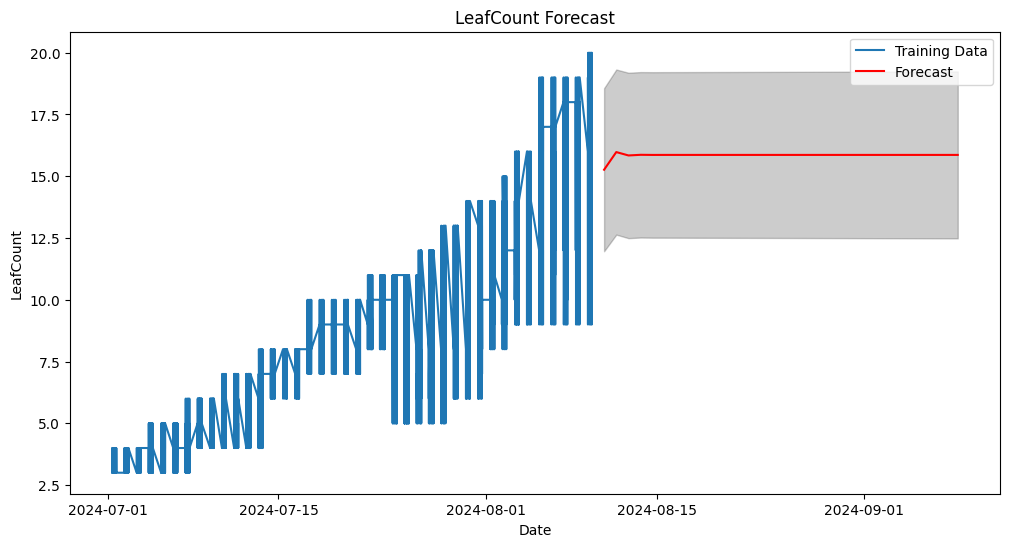

In [212]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train['LeafCount'], label='Training Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='r')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.2)
plt.title('LeafCount Forecast')
plt.xlabel('Date')
plt.ylabel('LeafCount')
plt.legend()
plt.show()

## Prophet Model

In [213]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [214]:
# df_train['datetime'] = pd.to_datetime(df_train['datetime'])
# df_train.set_index('datetime', inplace=True)

# df_test['datetime'] = pd.to_datetime(df_test['datetime'])
# df_test.set_index('datetime', inplace=True)

# Convert datetime to datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Prepare training data for Prophet
df_train_prophet = df_train[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_train_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

# Prepare test data for evaluation
df_test_prophet = df_test[['datetime', 'LeafCount', 'hole', 'temperature', 'humidity', 'light', 'pH', 'EC', 'TDS', 'WaterTemp']].copy()
df_test_prophet.rename(columns={'datetime': 'ds', 'LeafCount': 'y'}, inplace=True)

In [215]:
df_train_prophet

,ds,y,hole,temperature,humidity,light,pH,EC,TDS,WaterTemp
0,2024-07-01 08:55:00,3,1,25.3,92,21910,7.0,660,330,23.1
1,2024-07-01 08:57:00,3,2,25.3,92,21910,7.0,660,330,23.1
2,2024-07-01 08:59:00,3,3,25.5,92,21060,7.8,984,492,26.1
3,2024-07-01 08:59:00,4,3,25.5,92,21060,7.0,652,326,23.1
4,2024-07-01 09:02:00,3,4,25.7,92,28330,7.0,656,328,23.1
...,...,...,...,...,...,...,...,...,...,...
5278,2024-08-09 16:44:00,18,9,25.6,44,12820,7.5,1851,930,26.3
5279,2024-08-09 16:44:00,16,9,25.6,44,12820,7.5,1851,930,23.9
5280,2024-08-09 16:45:00,15,10,25.4,44,16810,7.5,1886,943,23.9
5281,2024-08-09 16:45:00,18,10,25.4,44,16810,7.5,1886,943,23.9


In [216]:
# Initialize Prophet model with additional regressors
model = Prophet()
model.add_regressor('hole')
model.add_regressor('temperature')
model.add_regressor('humidity')
model.add_regressor('light')
model.add_regressor('pH')
model.add_regressor('EC')
model.add_regressor('TDS')
model.add_regressor('WaterTemp')

# Fit the model
model.fit(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfcravcv/gnk88gyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfcravcv/o5b_f16v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64575', 'data', 'file=/tmp/tmpxfcravcv/gnk88gyh.json', 'init=/tmp/tmpxfcravcv/o5b_f16v.json', 'output', 'file=/tmp/tmpxfcravcv/prophet_modelvdqay20j/prophet_model-20240722033643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [217]:
# Create future dataframe for the next 30 days
future_dates = pd.date_range(start=df_test['datetime'].max(), periods=30, freq='D')
future = pd.DataFrame({'ds': future_dates})

In [218]:
# Fill in the future dataframe with the last known values of the regressors
future['hole'] = df_test['hole'].iloc[-1]
future['temperature'] = df_test['temperature'].iloc[-1]
future['humidity'] = df_test['humidity'].iloc[-1]
future['light'] = df_test['light'].iloc[-1]
future['pH'] = df_test['pH'].iloc[-1]
future['EC'] = df_test['EC'].iloc[-1]
future['TDS'] = df_test['TDS'].iloc[-1]
future['WaterTemp'] = df_test['WaterTemp'].iloc[-1]

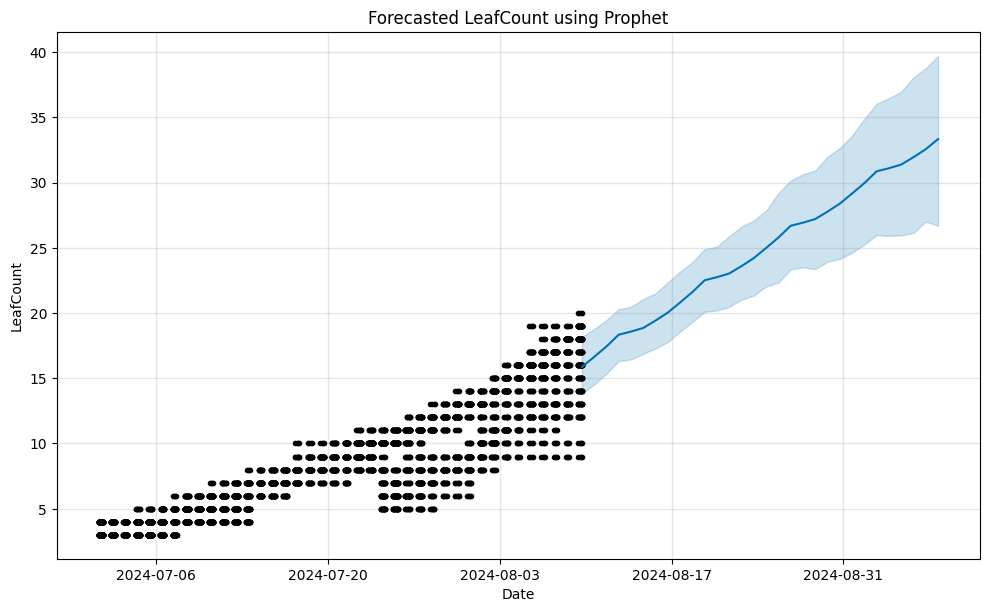

In [219]:
# Make predictions
forecast = model.predict(future)

# Visualize the forecast
fig = model.plot(forecast)
plt.title('Forecasted LeafCount using Prophet')
plt.xlabel('Date')
plt.ylabel('LeafCount')
plt.show()

In [220]:
# Create a table of the forecasted values
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_table.rename(columns={'ds': 'Date', 'yhat': 'Forecasted_LeafCount', 'yhat_lower': 'Lower_Bound', 'yhat_upper': 'Upper_Bound'}, inplace=True)

print(forecast_table)

                  Date  Forecasted_LeafCount  Lower_Bound  Upper_Bound
0  2024-08-09 16:45:00             15.860530    13.806774    18.159919
1  2024-08-10 16:45:00             16.634858    14.530301    18.771404
2  2024-08-11 16:45:00             17.432165    15.345431    19.460426
3  2024-08-12 16:45:00             18.338464    16.325360    20.291750
4  2024-08-13 16:45:00             18.575015    16.441931    20.482654
5  2024-08-14 16:45:00             18.856137    16.880813    21.074542
6  2024-08-15 16:45:00             19.420752    17.284570    21.507798
7  2024-08-16 16:45:00             20.035121    17.775244    22.354550
8  2024-08-17 16:45:00             20.809450    18.575230    23.178032
9  2024-08-18 16:45:00             21.606757    19.322404    23.899625
10 2024-08-19 16:45:00             22.513056    20.103964    24.892885
11 2024-08-20 16:45:00             22.749607    20.197026    25.084574
12 2024-08-21 16:45:00             23.030729    20.473838    25.892004
13 202

<ipython-input-220-7940988ce8cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_table.rename(columns={'ds': 'Date', 'yhat': 'Forecasted_LeafCount', 'yhat_lower': 'Lower_Bound', 'yhat_upper': 'Upper_Bound'}, inplace=True)


In [221]:
# Make predictions on the test set
test_forecast = model.predict(df_test_prophet)

In [222]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(df_test_prophet['y'], test_forecast['yhat']))
mae = mean_absolute_error(df_test_prophet['y'], test_forecast['yhat'])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 1.8057961508619482
MAE: 1.3954133718850414


### K-Fold Validation

In [223]:
# Function for K-Fold Cross Validation
def kfold_cross_validation(df, k=5):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k)
    rmse_scores = []
    mae_scores = []

    for train_index, val_index in kf.split(df):
        train_data = df.iloc[train_index]
        val_data = df.iloc[val_index]

        # Initialize new Prophet model for each fold
        model = Prophet()
        model.add_regressor('hole')
        model.add_regressor('temperature')
        model.add_regressor('humidity')
        model.add_regressor('light')
        model.add_regressor('pH')
        model.add_regressor('EC')
        model.add_regressor('TDS')
        model.add_regressor('WaterTemp')

        # Fit Prophet model
        model.fit(train_data)

        # Make predictions on validation set
        val_forecast = model.predict(val_data.drop(columns=['y']))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(val_data['y'], val_forecast['yhat']))
        mae = mean_absolute_error(val_data['y'], val_forecast['yhat'])

        rmse_scores.append(rmse)
        mae_scores.append(mae)

    # Aggregate metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)

    return avg_rmse, avg_mae

# Define the number of folds (k)
k = 5

# Perform K-Fold Cross Validation
kfold_rmse, kfold_mae = kfold_cross_validation(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfcravcv/vk3214t1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfcravcv/7ykep2g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61076', 'data', 'file=/tmp/tmpxfcravcv/vk3214t1.json', 'init=/tmp/tmpxfcravcv/7ykep2g6.json', 'output', 'file=/tmp/tmpxfcravcv/prophet_modelk0stjtpr/prophet_model-20240722033730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

In [224]:
print(f"Average RMSE across {k} folds: {kfold_rmse}")
print(f"Average MAE across {k} folds: {kfold_mae}")

Average RMSE across 5 folds: 1.7529163414905597
Average MAE across 5 folds: 1.4881282617085618
